# Análisis de Modelos Supervisados para la predicción de Overbooking
#### Integrantes: Álvaro Parker, Erick Bey y Matías Orozco
#### Modelos Analizados: KNN, Regresión Logística y Naive Bayes
#### Modelo Seleccionado: 

## Cada modelo tiene su propia limpieza de datos acorde al tipo de variable que maneja para la predicción.

# KNN (Álvaro Parker)

# Regrsión Logística (Erick Bey)

# Naive Bayes (Matías Orozco)

## Librerias Utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics as mt
import calendar

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Limpieza de datos

Transformamos las variables necesarias a formato numérico pedido por el modelo

In [3]:
def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)

    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = ["Mañana","Tarde","Noche"]
    le.fit(labels)
    df["hora"] = pd.DatetimeIndex(df["departure_time"]).hour
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    #
    le.fit(df["fligth_number"])
    df["fligth_number"] = le.fit_transform(df["fligth_number"])

    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [4]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")
df_procesado = df.copy()

# transformamos los datos a binarios
df_procesado["Labels"] = np.where(df_procesado["noshow"] >= 4, 1,0)

# Procesamos los datos con la funcion procesar_csv()
df_procesado = procesar_csv(df_procesado)

# Definimos nuestra columna target
target = df_procesado['Labels']

# La eliminamos del dataframe
df_procesado.drop('noshow', axis=1, inplace=True)
df_procesado.drop('Labels', axis=1, inplace=True)

#### Columnas post procesamiento de datos

In [5]:
df_procesado.columns

Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'bookings',
       'origin_int', 'destination_int', 'revenues_usd_discr', 'mes', 'hora'],
      dtype='object')

#### Distribución de datos de cada variable

<AxesSubplot:title={'center':'fligth_number'}>

<AxesSubplot:title={'center':'distance'}>

<AxesSubplot:title={'center':'denied_boarding'}>

<AxesSubplot:title={'center':'pax_midlow'}>

<AxesSubplot:title={'center':'pax_high'}>

<AxesSubplot:title={'center':'pax_midhigh'}>

<AxesSubplot:title={'center':'pax_low'}>

<AxesSubplot:title={'center':'pax_freqflyer'}>

<AxesSubplot:title={'center':'group_bookings'}>

<AxesSubplot:title={'center':'out_of_stock'}>

<AxesSubplot:title={'center':'dom_cnx'}>

<AxesSubplot:title={'center':'int_cnx'}>

<AxesSubplot:title={'center':'p2p'}>

<AxesSubplot:title={'center':'capacity'}>

<AxesSubplot:title={'center':'bookings'}>

<AxesSubplot:title={'center':'origin_int'}>

<AxesSubplot:title={'center':'destination_int'}>

<AxesSubplot:title={'center':'revenues_usd_discr'}>

<AxesSubplot:title={'center':'mes'}>

<AxesSubplot:title={'center':'hora'}>

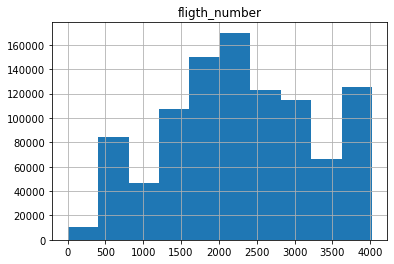

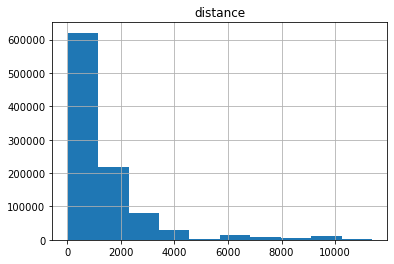

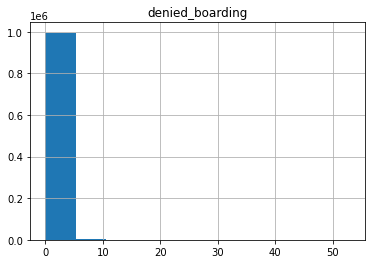

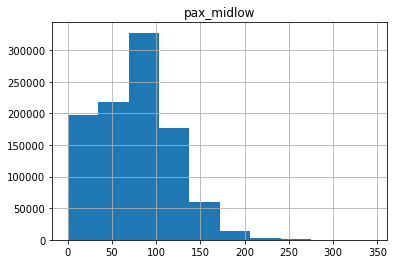

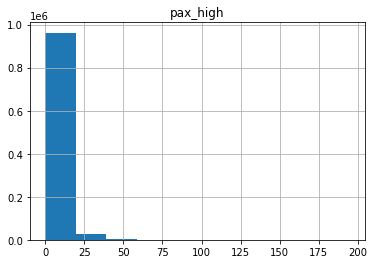

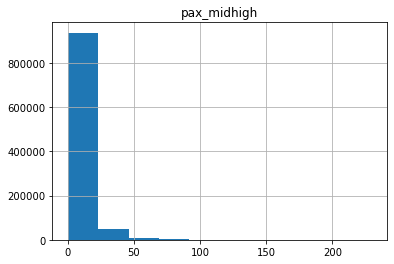

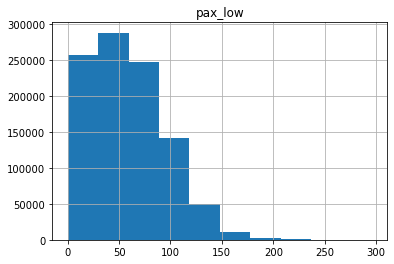

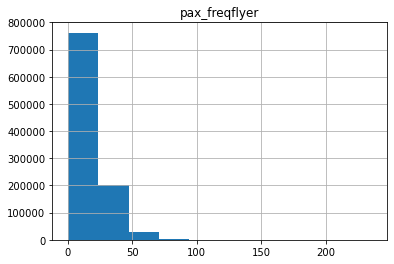

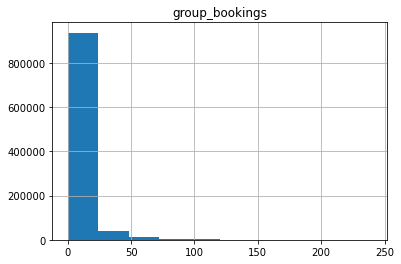

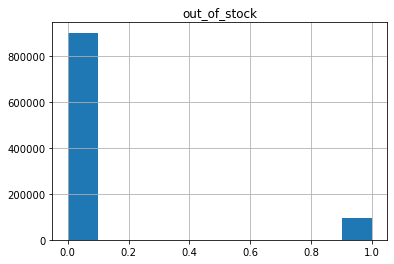

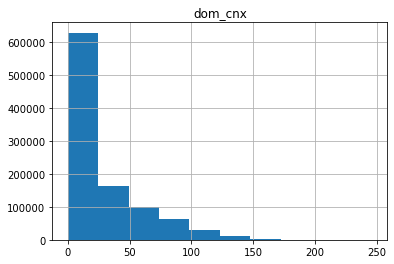

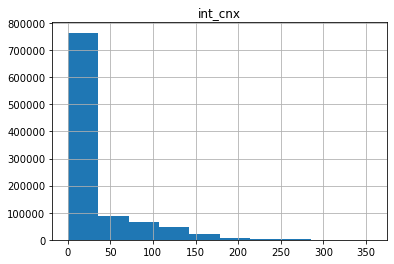

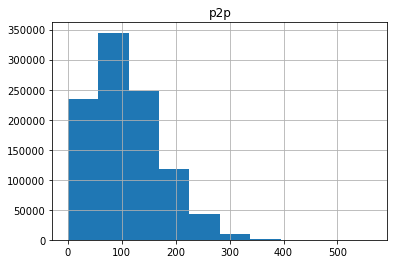

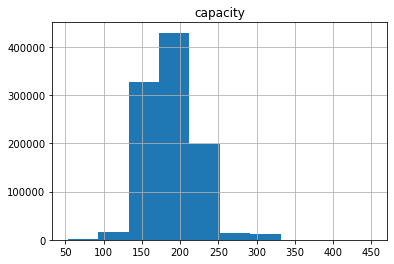

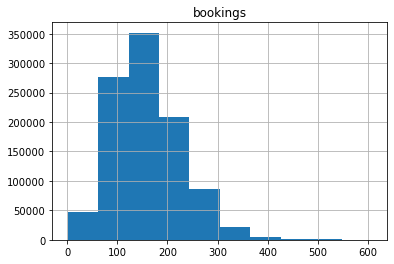

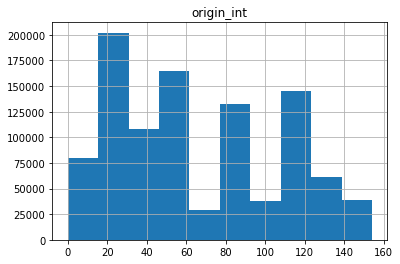

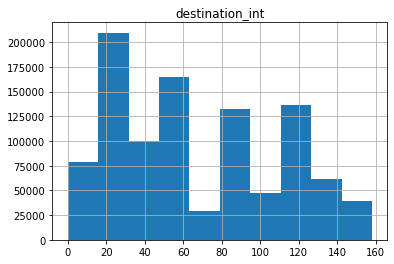

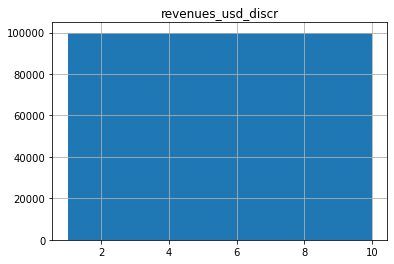

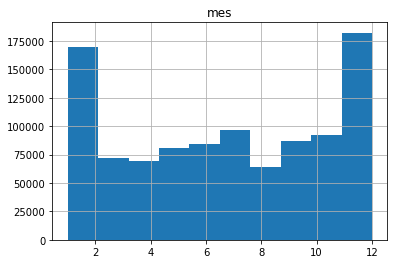

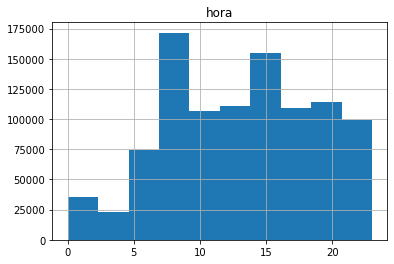

In [6]:
for i in df_procesado.columns:
    plt.figure()
    plt.title(i)
    display(df_procesado[i].hist())

### Se usará K-Fold Cross Validation con Undersampling para calcular los Score
Debido a que las clases se encuentran desbalanceadas, se utilizó una muestra más pequeña de la clase 1 para evitar el overfitting del modelo.

## MultinomialNB (alpha = 0,1,10,100)
Aplicamos el modelo con distintos valores de Laplace y agregando variables 1 por 1 para ver si existe alguna cantidad de variables óptima.

In [8]:
Multinomial0 = []
Multinomial1 = []
Multinomial10 = []
Multinomial100 = []

m = 1
while(m < len(df_procesado.columns)):
    display(df_procesado.iloc[:,:m])
    
    TrainF1Score_general = []
    TestF1Score_general = []

    for j in [0,1,10,100]:
    #Crear un objeto de KFold cross validation
        k = 100
        kf = KFold(n_splits = k, shuffle = True, random_state = 42)

        NB = MultinomialNB(alpha = j)
        #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
        F1Train = np.zeros(k)
        F1Test = np.zeros(k)

        i=0
        #Aplicar K-fold cross validation
        for train_index, test_index in kf.split(df_procesado.iloc[:,:m]):
            #extraer los datos de entrenamiento y test
                #Train
                trainData = df_procesado.iloc[:,:m].iloc[train_index, :]
                trainLabel = target.iloc[train_index]

                yes_overbook = trainData[trainLabel == 1]
                no_overbook = trainData[trainLabel == 0]

                yes_overbook = yes_overbook.sample(no_overbook.shape[0])

                trainData = yes_overbook.append(no_overbook)
                trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

                #Test
                testData = df_procesado.iloc[:,:m].iloc[test_index, :]
                testLabel = target.iloc[test_index]

                #Entrenar el modelo usando los datos de entrenamiento
                NB = NB.fit(trainData, trainLabel)

                #Predecir los valores de TrainData y calcule su error
                prediccion = NB.predict(trainData)
                F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

                #Prediga los valores de testData y calcule su error
                prediccion = NB.predict(testData)
                F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

                i+=1
                if(i == k):
                    TrainF1Score_general.append(F1Train)
                    TestF1Score_general.append(F1Test)

                print(i, end=" ")
        if j == 0: Multinomial0.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 1: Multinomial1.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 10: Multinomial10.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 100: Multinomial100.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        print("\nF1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
        print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  
    m+=1

,fligth_number
0,3799
1,2869
2,3776
3,2267
4,3051
...,...
999885,2252
999886,2567
999887,3886
999888,3045


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.6666666666666669 +- 2.220446049250313e-16
F1-score modelo para test:  0.512365931337665 +- 0.0049056167611591685
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.6666666666666669 +- 2.220446049250313e-16
F1-score modelo para test:  0.512365931337665 +- 0.0049056167611591685
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

,fligth_number,distance
0,3799,1394
1,2869,489
2,3776,2180
3,2267,524
4,3051,1170
...,...,...
999885,2252,552
999886,2567,3934
999887,3886,1430
999888,3045,1091


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4630122005861123 +- 0.0001690144322864414
F1-score modelo para test:  0.39698195765051686 +- 0.007897386767484199
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4630249116458598 +- 0.00018823288713029333
F1-score modelo para test:  0.3969989250194564 +- 0.007901775888290559
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 4

,fligth_number,distance,denied_boarding
0,3799,1394,0
1,2869,489,0
2,3776,2180,0
3,2267,524,0
4,3051,1170,0
...,...,...,...
999885,2252,552,0
999886,2567,3934,0
999887,3886,1430,0
999888,3045,1091,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4630225292642633 +- 0.00019700271185518422
F1-score modelo para test:  0.39700012665330064 +- 0.007891018522339654
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46302538071941834 +- 0.00018143353783430882
F1-score modelo para test:  0.3969937040782953 +- 0.007903244754565594
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42

,fligth_number,distance,denied_boarding,pax_midlow
0,3799,1394,0,94
1,2869,489,0,100
2,3776,2180,0,7
3,2267,524,0,54
4,3051,1170,0,21
...,...,...,...,...
999885,2252,552,0,25
999886,2567,3934,0,129
999887,3886,1430,0,2
999888,3045,1091,0,67


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4632193938396602 +- 0.000175558116998198
F1-score modelo para test:  0.396993733402436 +- 0.007894227166921626
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46320446350861566 +- 0.0001746768919109525
F1-score modelo para test:  0.39697878372653717 +- 0.007908123171595133
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high
0,3799,1394,0,94,2
1,2869,489,0,100,4
2,3776,2180,0,7,1
3,2267,524,0,54,4
4,3051,1170,0,21,88
...,...,...,...,...,...
999885,2252,552,0,25,12
999886,2567,3934,0,129,3
999887,3886,1430,0,2,1
999888,3045,1091,0,67,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4632594185648086 +- 0.00016313296142609742
F1-score modelo para test:  0.39703042404001737 +- 0.007907682893029807
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46323414787746686 +- 0.00019972090758402033
F1-score modelo para test:  0.39700889853608495 +- 0.007890976605397082
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh
0,3799,1394,0,94,2,28
1,2869,489,0,100,4,4
2,3776,2180,0,7,1,5
3,2267,524,0,54,4,7
4,3051,1170,0,21,88,18
...,...,...,...,...,...,...
999885,2252,552,0,25,12,20
999886,2567,3934,0,129,3,19
999887,3886,1430,0,2,1,0
999888,3045,1091,0,67,2,7


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4632380737845565 +- 0.0001937414327494122
F1-score modelo para test:  0.39698759023025615 +- 0.007915319525589357
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46323045797027235 +- 0.00021274192835317037
F1-score modelo para test:  0.3969858856495288 +- 0.007916786218826658
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low
0,3799,1394,0,94,2,28,94
1,2869,489,0,100,4,4,87
2,3776,2180,0,7,1,5,64
3,2267,524,0,54,4,7,21
4,3051,1170,0,21,88,18,82
...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4
999886,2567,3934,0,129,3,19,121
999887,3886,1430,0,2,1,0,108
999888,3045,1091,0,67,2,7,42


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46291892968243203 +- 0.0002242778921118135
F1-score modelo para test:  0.3971415240374676 +- 0.007887016249220462
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4629400118711684 +- 0.00021380140153497824
F1-score modelo para test:  0.3971374233810536 +- 0.007897876721127794
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer
0,3799,1394,0,94,2,28,94,22
1,2869,489,0,100,4,4,87,25
2,3776,2180,0,7,1,5,64,2
3,2267,524,0,54,4,7,21,4
4,3051,1170,0,21,88,18,82,0
...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12
999886,2567,3934,0,129,3,19,121,2
999887,3886,1430,0,2,1,0,108,20
999888,3045,1091,0,67,2,7,42,16


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46265080246720586 +- 0.0002420723244702196
F1-score modelo para test:  0.3969179281400489 +- 0.007931798718808395
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46269397865560835 +- 0.00020535847918602403
F1-score modelo para test:  0.396928160477793 +- 0.007929330360160056
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings
0,3799,1394,0,94,2,28,94,22,19
1,2869,489,0,100,4,4,87,25,0
2,3776,2180,0,7,1,5,64,2,0
3,2267,524,0,54,4,7,21,4,0
4,3051,1170,0,21,88,18,82,0,88
...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0
999886,2567,3934,0,129,3,19,121,2,20
999887,3886,1430,0,2,1,0,108,20,36
999888,3045,1091,0,67,2,7,42,16,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46379298674313135 +- 0.00020869523784517385
F1-score modelo para test:  0.39795956197650684 +- 0.0077468356596670064
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46377954962770573 +- 0.0002105496465439673
F1-score modelo para test:  0.39796976849168125 +- 0.007738090930576308
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock
0,3799,1394,0,94,2,28,94,22,19,0
1,2869,489,0,100,4,4,87,25,0,0
2,3776,2180,0,7,1,5,64,2,0,0
3,2267,524,0,54,4,7,21,4,0,0
4,3051,1170,0,21,88,18,82,0,88,1
...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0
999886,2567,3934,0,129,3,19,121,2,20,0
999887,3886,1430,0,2,1,0,108,20,36,0
999888,3045,1091,0,67,2,7,42,16,0,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46380099142585396 +- 0.00022725347273361293
F1-score modelo para test:  0.39793365934370806 +- 0.00771830357170741
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4637881272186627 +- 0.00022285976173161675
F1-score modelo para test:  0.3979612895858115 +- 0.007740669880167289
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx
0,3799,1394,0,94,2,28,94,22,19,0,1
1,2869,489,0,100,4,4,87,25,0,0,19
2,3776,2180,0,7,1,5,64,2,0,0,0
3,2267,524,0,54,4,7,21,4,0,0,26
4,3051,1170,0,21,88,18,82,0,88,1,23
...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64
999886,2567,3934,0,129,3,19,121,2,20,0,0
999887,3886,1430,0,2,1,0,108,20,36,0,7
999888,3045,1091,0,67,2,7,42,16,0,0,34


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46503415409493654 +- 0.00019352815953276031
F1-score modelo para test:  0.3989218482941482 +- 0.007694077065649898
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4650123323555887 +- 0.0001747482997648733
F1-score modelo para test:  0.39892852121322603 +- 0.007730760874134886
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx
0,3799,1394,0,94,2,28,94,22,19,0,1,0
1,2869,489,0,100,4,4,87,25,0,0,19,9
2,3776,2180,0,7,1,5,64,2,0,0,0,10
3,2267,524,0,54,4,7,21,4,0,0,26,0
4,3051,1170,0,21,88,18,82,0,88,1,23,3
...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9
999886,2567,3934,0,129,3,19,121,2,20,0,0,118
999887,3886,1430,0,2,1,0,108,20,36,0,7,0
999888,3045,1091,0,67,2,7,42,16,0,0,34,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4619757939297358 +- 0.00025755444974534205
F1-score modelo para test:  0.39652232384464775 +- 0.007662461352836431
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46198870681203597 +- 0.0002376167455598905
F1-score modelo para test:  0.3965123922358428 +- 0.007694959725860516
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239
1,2869,489,0,100,4,4,87,25,0,0,19,9,192
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69
3,2267,524,0,54,4,7,21,4,0,0,26,0,64
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45558593417877097 +- 0.000332900417249085
F1-score modelo para test:  0.3919778641726863 +- 0.007705652937365767
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45560018238040034 +- 0.00036428678853810787
F1-score modelo para test:  0.3919864727388518 +- 0.007704998105519458
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45620866575164487 +- 0.0003187526780462496
F1-score modelo para test:  0.39243621283502295 +- 0.007687649575537153
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45617097676580703 +- 0.00033503272165112154
F1-score modelo para test:  0.39241390372800355 +- 0.007671718637769102
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45399125775555194 +- 0.0003395607029682129
F1-score modelo para test:  0.39096637538240436 +- 0.007623005049056536
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45398517930481497 +- 0.0003655081633380206
F1-score modelo para test:  0.3909125249087392 +- 0.007717872485591479
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45403579508069897 +- 0.0003904573926674364
F1-score modelo para test:  0.3910624867468722 +- 0.007755230423569014
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45412887016061687 +- 0.0004126588170838496
F1-score modelo para test:  0.3910753816239929 +- 0.0077740948568747244
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12,125
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79,143
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122,116
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27,33
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143,27
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79,57
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62,125
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53,126


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45402623056365804 +- 0.00038366765115831
F1-score modelo para test:  0.3910834315524461 +- 0.007655322996131702
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45399881743352594 +- 0.0003966831232226086
F1-score modelo para test:  0.3910369970420078 +- 0.0075734744563395765
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12,125,6
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79,143,2
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122,116,8
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27,33,6
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51,55,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143,27,8
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79,57,10
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62,125,7
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53,126,5


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45421412558726293 +- 0.00037503872040306404
F1-score modelo para test:  0.3912724779565513 +- 0.007646338690533731
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45425749536342225 +- 0.0004071983218323887
F1-score modelo para test:  0.3912352430125416 +- 0.007651273502436991
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr,mes
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12,125,6,11
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79,143,2,5
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122,116,8,5
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27,33,6,2
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51,55,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143,27,8,10
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79,57,10,5
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62,125,7,4
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53,126,5,4


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45436726594277954 +- 0.0003811229104386142
F1-score modelo para test:  0.3912988933299434 +- 0.007616034267420037
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4543042281968179 +- 0.000372646539391572
F1-score modelo para test:  0.3913219581833365 +- 0.007647821410994654
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

No handles with labels found to put in legend.


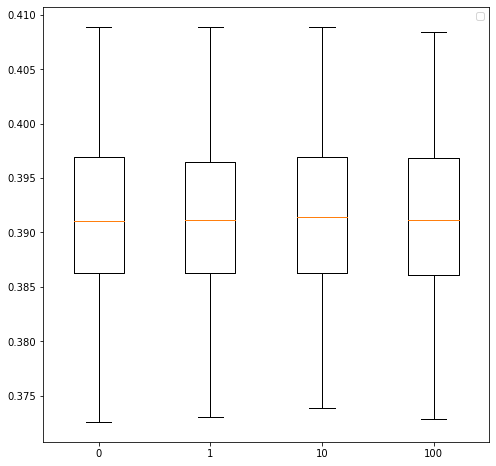

In [10]:
plt.figure(figsize=(8, 8))

plt.boxplot(TestF1Score_general)
plt.xticks([1, 2, 3, 4], ["0","1","10","100"])
plt.legend()
plt.show()

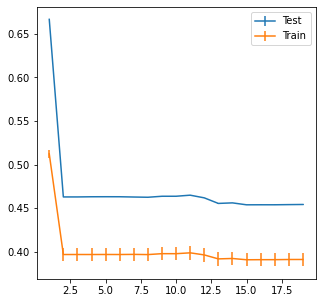

In [11]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Multinomial0)):
    TrainMeans.append(Multinomial0[i][0].mean())
    TrainSTD.append(Multinomial0[i][0].std())
    TestMeans.append(Multinomial0[i][1].mean())
    TestSTD.append(Multinomial0[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(1,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Test")
plt.errorbar(range(1,len(df_procesado.columns)), TestMeans, TestSTD, label = "Train")
plt.legend()
plt.xticks(range(1,len(df_procesado.columns)),1)
plt.show()

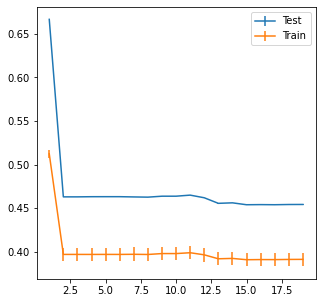

In [12]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Multinomial1)):
    TrainMeans.append(Multinomial1[i][0].mean())
    TrainSTD.append(Multinomial1[i][0].std())
    TestMeans.append(Multinomial1[i][1].mean())
    TestSTD.append(Multinomial1[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(1,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Test")
plt.errorbar(range(1,len(df_procesado.columns)), TestMeans, TestSTD, label = "Train")
plt.legend()
plt.show()

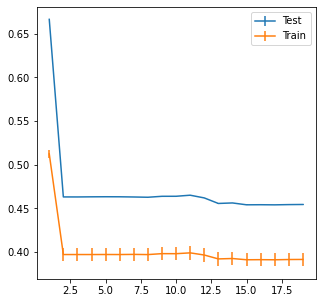

In [13]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Multinomial10)):
    TrainMeans.append(Multinomial10[i][0].mean())
    TrainSTD.append(Multinomial10[i][0].std())
    TestMeans.append(Multinomial10[i][1].mean())
    TestSTD.append(Multinomial10[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(1,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Test")
plt.errorbar(range(1,len(df_procesado.columns)), TestMeans, TestSTD, label = "Train")
plt.legend()
plt.show()

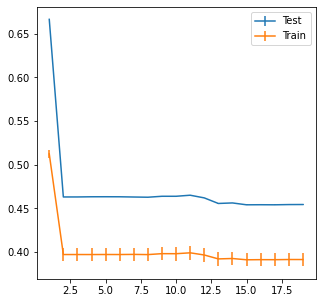

In [14]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Multinomial100)):
    TrainMeans.append(Multinomial100[i][0].mean())
    TrainSTD.append(Multinomial100[i][0].std())
    TestMeans.append(Multinomial100[i][1].mean())
    TestSTD.append(Multinomial100[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(1,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Test")
plt.errorbar(range(1,len(df_procesado.columns)), TestMeans, TestSTD, label = "Train")
plt.legend()
plt.show()

# Train y Test Final

In [ ]:
# Leemos los datos
dftrain = pd.read_csv("ALUMNOS-trainData.csv")
dftrain_procesado = dftrain.copy()

# transformamos los datos a binarios
dftrain_procesado["Labels"] = np.where(dftrain_procesado["noshow"] >= 4, 1,0)

# Procesamos los datos con la funcion procesar_csv()
dftrain_procesado = procesar_csv(dftrain_procesado)

# Definimos nuestra columna target
target = dftrain_procesado['Labels']

# La eliminamos del dataframe
dftrain_procesado.drop('noshow', axis=1, inplace=True)
dftrain_procesado.drop('Labels', axis=1, inplace=True)

df_procesado.drop('out_of_stock', axis=1, inplace=True)

In [ ]:
# Leemos los datos
dftest = pd.read_csv("ALUMNOS-evalData.csv")

# Procesamos los datos con la funcion procesar_csv()
df_procesado = procesar_csv(df_procesado)

# Definimos nuestra columna target
target = df_procesado['Labels']

# La eliminamos del dataframe
df_procesado.drop('noshow', axis=1, inplace=True)
df_procesado.drop('Labels', axis=1, inplace=True)